# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy

In [2]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice'
fitted_param_plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
plot_dir = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots"
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'

# Functions for simulating data

In [3]:
class WSLSAgent():
    
    def __init__(self, n_agents, params, model_name, p_right=0.5, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.beta = self.params['beta'].values
        self.bias = self.params['bias'].values
        self.p_right = p_right * np.ones((n_agents, 2))
        self.model_name = model_name
        self.avail_actions = (0, 1)
        self.prev_action = np.full(n_agents, np.nan)
        self.prev_reward = np.full(n_agents, np.nan)

    def p_from_prev_WSLS(self, action, reward):
        """
        Look up which action should be taken next, based on previous action(s) and outcome(s),
        using either the win-stay loose-shift (WSLS) strategy, or a 2-trial-back version of WSLS.
        """

        # Makes you choose right
        r1 = action * reward  # r1: right, reward
        l0 = (1 - action) * (1 - reward)  # l0: left, no reward
        l0l0 = (1 - self.prev_action) * (1 - self.prev_reward) * (1 - action) * (1 - reward)
        r1l0 = self.prev_action * self.prev_reward * (1 - action) * (1 - reward)
        r0l0 = self.prev_action * (1 - self.prev_reward) * (1 - action) * (1 - reward)
        r1r0 = self.prev_action * self.prev_reward * action * (1 - reward)

        # Makes you choose left
        r0 = action * (1 - reward)  # r0: right, no reward
        l1 = (1 - action) * reward  # l1: left, reward
        r0r0 = self.prev_action * (1 - self.prev_reward) * action * (1 - reward)
        l1r0 = (1 - self.prev_action) * self.prev_reward * action * (1 - reward)
        l0r0 = (1 - self.prev_action) * (1 - self.prev_reward) * action * (1 - action)
        l1l0 = (1 - self.prev_action) * self.prev_reward * (1 - action) * (1 - reward)

        if (self.model_name == 'WSLS') or (np.isnan(self.prev_action[0])):
            
#             ipdb.set_trace()
            self.p_right = scipy.special.softmax(-self.beta * np.array([
                r1 + l0 + self.bias,  # favoring right
                l1 + r0,  # favoring left
            ]).T, axis=1)

        else:

            self.p_right = scipy.special.softmax(-self.beta * np.array([
                r1 + l0l0 + r1l0 + r0l0 + r1r0 + self.bias,  # favoring right
                l1 + r0r0 + l1r0 + l0r0 + l1l0  # favoring left
            ]).T, axis=1)
            
        self.prev_action = action.copy()
        self.prev_reward = reward.copy()

        return self.p_right

    def take_action(self):
        """
        Take 1 action per agent, based on current trial likelihoods and priors.
        """
        
        action = np.array(
            [np.random.choice(self.avail_actions, p=self.p_right[a])
             for a in range(self.n_agents)])
        
        return self.p_right, action
        
# # Example use
# params = pd.DataFrame({
#     'beta': [4], 'bias': [0],
# })
# agent = WSLSAgent(n_agents, params, 'WSLS')

# # Simulate three trials
# lik, action = agent.take_action()
# print("Trial 1:", action)

# action = np.zeros(n_agents)
# reward = np.ones(n_agents)

# p_right = agent.p_from_prev_WSLS(action, reward)
# lik, action = agent.take_action()
# print("Trial 2:", action)

# action = np.zeros(n_agents)
# reward = np.zeros(n_agents)

# p_right = agent.p_from_prev_WSLS(action, reward)
# lik, action = agent.take_action()
# print("Trial 3:", action)

In [4]:
class RLAgent():
    
    def __init__(self, n_agents, params, forced_actions=[], init_Q=1/2, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.avail_actions = (0, 1)
        self.init_Q = init_Q
        self.Q = init_Q * np.ones((n_agents, len(self.avail_actions)))
        self.eps = eps
        self.prev_action = np.full(n_agents, np.nan)
        self.forced_actions = list(forced_actions)
        
    def take_action(self):
        """
        Take 1 action per agent, based on current trial Q-values.
        """
        
        ags = np.arange(self.n_agents)

        # Perseveration
        Q0 = self.Q[ags, 0]
        Q1 = self.Q[ags, 1]
        if not np.isnan(self.prev_action[0]):  # prev_action is np.nan on trial 0 only; only checking first element for simplicity
            Q0 += (1 - self.prev_action) * self.params['persev'].values  # action 0: subtract persev when repeating
            Q1 += self.prev_action * self.params['persev'].values   # action 1: add persev when repeating

        # Action selection
        lik = scipy.special.softmax(self.params['beta'].values * np.array([Q0, Q1]).T, axis=1)
        if self.forced_actions:
            action = self.forced_actions.pop(0) * np.ones(self.n_agents).astype(int)
        else:
            action = np.array([np.random.choice(self.avail_actions, p=lik[a]) for a in range(self.n_agents)])
        
        self.prev_action = action.copy()
        NLL = -np.log(lik[np.arange(self.n_agents), action])
        
        return NLL, action
    
    def update_Q(self, action, reward):
        """
        Update Q-values based on RL.
        """
        
        ags = np.arange(self.n_agents)
        
        rpe = (1 - self.Q[ags, action]) * reward  # received reward, updating chosen action
        nrpe = (0 - self.Q[ags, action]) * (1 - reward)  # received no reward, updating chosen action
        
        crpe = (0 - self.Q[ags, 1-action]) * reward  # received reward, updating unchosen action
        cnrpe = (1 - self.Q[ags, 1-action]) * (1 - reward)  # received no reard, updating unchosen action
        
        self.Q[ags, action] += self.params['alpha'].values * rpe + self.params['nalpha'].values * nrpe
        self.Q[ags, 1-action] += self.params['calpha'].values * crpe + self.params['cnalpha'].values * cnrpe

# Example use:
n_agents = 100
params = pd.DataFrame({
    'alpha': [0.8], 'nalpha': [0.1], 'calpha': [0.9], 'cnalpha': [0.1],
    'beta': [4], 'persev': [0.2], 'bias': [0]
})

agent = RLAgent(n_agents, params)
lik, action = agent.take_action()
print("action", action)
# correct, reward = task.present_reward(action, trial)
# print("reward", reward)
# agent.update_Q(action, reward)
# print("agent.Q", agent.Q)

action [0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0
 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0]


In [5]:
class BFAgent():
    
    def __init__(self, n_agents, params, forced_actions=[], p_r=0.5, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.p_reward = self.params['p_reward'].values
        self.p_switch = self.params['p_switch'].values
        self.beta = self.params['beta'].values
        self.persev = self.params['persev'].values
        self.bias = self.params['bias'].values
        self.p_r = p_r * np.ones(n_agents)  # Bayesian posterior probability of selecting right (propagated through trials)
        self.p_right = p_r * np.ones((n_agents, 2))  # behavioral probability of selecting right (log-transformed and with perseverance bonus)
        self.p_noisy = eps
        self.avail_actions = (0, 1)
        self.prev_action = np.full(n_agents, np.nan)
        self.forced_actions = list(forced_actions)

    def take_action(self):
        """
        Take 1 action per agent, based on current trial likelihoods and priors.
        """
        
        if np.isnan(self.beta):  # Basic Bayesian model, no free parameters
            self.p_right = np.array([1 - self.p_r, self.p_r]).T  # self.p_r is the actual probability; self.p_right is after adding perseverance etc.

        if self.forced_actions:
            action = self.forced_actions.pop(0) * np.ones(self.n_agents).astype(int)
        else:
            action = np.array(
                [np.random.choice(self.avail_actions, p=self.p_right[a])
                 for a in range(self.n_agents)]).astype(int)
        self.prev_action = action.copy()
        
        NLL = -np.log(self.p_right[np.arange(self.n_agents), action])
        
        return NLL, action
        
    def get_likelihoods(self, action, reward):
        
        # p(r=r|choice=correct): Likelihood of outcome (reward 0 or 1) given choice was correct:
        #           |   reward==1   |   reward==0
        #           |---------------|-----------------
        # choice==1 | p_reward      | 1 - p_reward
        # choice==0 | p_noisy       | 1 - p_noisy

        lik_cor_rew1 = action * self.p_reward + (1 - action) * self.p_noisy
        lik_cor_rew0 = action * (1 - self.p_reward) + (1 - action) * (1 - self.p_noisy)
        self.lik_cor = reward * lik_cor_rew1 + (1 - reward) * lik_cor_rew0

        # p(r=r|choice=incorrect): Likelihood of outcome (reward 0 or 1) given choice was incorrect:
        #           |   reward==1   |   reward==0
        #           |---------------|-----------------
        # choice==1 | p_noisy       | 1 - p_noisy
        # choice==0 | p_reward      | 1 - p_reward

        lik_inc_rew1 = action * self.p_noisy + (1 - action) * self.p_reward
        lik_inc_rew0 = action * (1 - self.p_noisy) + (1 - action) * (1 - self.p_reward)
        self.lik_inc = reward * lik_inc_rew1 + (1 - reward) * lik_inc_rew0

        return self.lik_cor, self.lik_inc
        
    def update_priors(self, action, reward):
        
        # Apply Bayes rule: Posterior prob. that right action is correct, based on likelihood (i.e., received feedback)
        self.p_r = self.lik_cor * self.p_r / (self.lik_cor * self.p_r + self.lik_inc * (1 - self.p_r))

        # Take into account that a switch might occur
        self.p_r = (1 - self.p_switch) * self.p_r + self.p_switch * (1 - self.p_r)
        
        # Add perseverance bonus
        if not np.isnan(self.prev_action[0]):  # prev_action is np.nan on trial 0 only; only checking first element for simplicity
            persev_bonus = 2 * self.prev_action - 1  # -1 for choice==0 (left) and +1 for choice==1 (right)
            scaled_persev_bonus = persev_bonus * self.persev
            p_right0 = self.p_r + scaled_persev_bonus
        else:
            p_right0 = self.p_r.copy()

        # Log-transform probabilities
        self.p_right = scipy.special.softmax(-self.beta * np.array([p_right0 + self.bias, (1 - p_right0)]).T, axis=1)
#         self.p_right = 0.0001 + 0.9998 * self.p_right  # make 0.0001 < p_right < 0.9999

        # p_r is the actual probability of right, which is the prior for the next trial
        # p_right is p_r after adding perseveration and log-transform, used to select actions
        return self.p_r, self.p_right, p_right0
        
# Example use
params = pd.DataFrame({
    'p_reward': [0.75], 'p_switch': [0.05], 'beta': [np.nan], 'persev': [0], 'bias': [0],
})
n_agents = 3
agent = BFAgent(n_agents, params)

lik, action = agent.take_action()

action = np.ones(n_agents)
reward = np.ones(n_agents)

lik_cor, lik_inc = agent.get_likelihoods(action=action, reward=reward)
lik_cor, lik_inc

p_r, p_right, p_right0 = agent.update_priors(action=action, reward=reward)
p_r, p_right, p_right0

lik, action = agent.take_action()
action

array([1, 1, 1])

In [19]:
class PSTask():
    
    def __init__(self, correct_actions, p_cor=0.75,
                 forced_rewards=[],
                 n_trials=[], block_lengths_lower=[], block_lengths_upper=[]):
        """
        Must either provide block_lengths_lower and block_lengths_upper -> task will be created on the fly;
        or correct_actions -> provided task will be used.
        """
        
        self.p_cor = p_cor
        self.forced_rewards = list(forced_rewards)

        if len(correct_actions) > 0:
            self.correct_actions = correct_actions
            self.n_trials = len(correct_actions)
        elif block_lengths_lower > 0: 
            self.block_lengths_lower = block_lengths_lower
            self.block_lengths_upper = block_lengths_upper
            self.n_trials = n_trials
            self.correct_actions = self.make_task()
        else:
            raise ValueError("You must provide either correct_actions or block_lengths_lower.")
        
    def make_task(self):
        """
        Currently just produces the same sequence of correct and incorrect boxes for each animal.
        In future, will read in animal data.
        """
        
        correct_actions = []
        block_lengths = np.random.randint(
            low=self.block_lengths_lower, high=self.block_lengths_upper, size=self.n_trials)

        for block_length, correct_side in zip(block_lengths, [0, 1] * self.n_trials):
            correct_actions += block_length * [correct_side]
        
        correct_actions = correct_actions[:self.n_trials]
        
        return correct_actions
        
    def get_chance_rewards(self, n_correct_choices):
        """
        Translate accuracy into rewards:
        Return '1' with probability self.p_cor and '0' with probability 1-self.p_cor, for each agent.
        """
        
        return np.array([np.random.choice((0, 1), p=(1-self.p_cor, self.p_cor)) for i in range(n_correct_choices)])

    def present_reward(self, action, trial):
        """
        Present reward (0, 1) for each agent in this trial, based on choices,
        by consulting the correct_box on the current trial.
        """
        
#         ipdb.set_trace()
        correct = np.array(self.correct_actions[trial] == action).astype(int)
        if self.forced_rewards:
            reward = self.forced_rewards.pop(0) * np.ones_like(correct)
        else:
            reward = correct.copy()
            reward[reward == 1] = self.get_chance_rewards(sum(reward==1))
        
        return correct, reward
    
# Example use
n_trials = 725
block_lengths_lower = 40
block_lengths_upper = 41
n_agents = 10

task = PSTask(
    n_trials=n_trials, block_lengths_lower=block_lengths_lower, block_lengths_upper=block_lengths_upper,
    correct_actions=[])
task.make_task()

task.get_chance_rewards(n_correct_choices=100)

action = np.zeros(n_agents)
trial = 0
task.present_reward(action, trial)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 1, 1, 1, 1, 1, 0, 0, 1, 1]))

In [127]:
def simulate_dataset(task_args, agent_args, model_class, suff=''):
    
    actions = []
    liks = []
    rewards = []
    corrects = []

    # Get task and agent
    task = PSTask(correct_actions=task_args['correct_actions'], forced_rewards=task_args['forced_rewards'],
                  n_trials=task_args['n_trials'],
                  block_lengths_lower=task_args['block_lengths_lower'], block_lengths_upper=task_args['block_lengths_upper'])
    if (model_class == 'BF') or (model_class == 'B'):
        agent = BFAgent(agent_args['n_agents'], agent_args['params'], agent_args['forced_actions'])
    elif (model_class == 'RL') or (model_class == 'R'):
        agent = RLAgent(agent_args['n_agents'], agent_args['params'], agent_args['forced_actions'])
    elif model_class == 'WSLS':
        agent = WSLSAgent(agent_args['n_agents'], agent_args['params'], agent_args['model_name'], agent_args['forced_actions'])

    # Play the game, save data
    for trial in range(task_args['n_trials']):

        lik, action = agent.take_action()
        correct, reward = task.present_reward(action, trial)
        
        if (model_class == 'BF') or (model_class == 'B'):
            agent.get_likelihoods(action, reward)
            agent.update_priors(action, reward)
        elif (model_class == 'RL') or (model_class == 'R'):
            agent.update_Q(action, reward)
        elif model_class == 'WSLS':
            agent.p_from_prev_WSLS(action, reward)
            
        actions += [action]
        liks += [lik]
        rewards += [reward]
        corrects += [correct]

    # Format data
    data = pd.DataFrame(
            {'action' + suff: actions, 'lik' + suff: liks,
             'reward' + suff: rewards, 'correct' + suff: corrects, 'correct_action': task.correct_actions})
    data = data.reset_index()
    data = data.rename(columns={'index': 'trial'})

    data['mean_reward'] = np.mean(np.array(list(data['reward' + suff])), axis=1)
    data['mean_correct'] = np.mean(np.array(list(data['correct' + suff])), axis=1)
    data['block'] = np.append([0], np.cumsum(np.abs(np.diff(task.correct_actions))))

    return data

# Example use
task_args = {
    'correct_actions': [], 'n_trials': 120,
    'block_lengths_lower': 10, 'block_lengths_upper': 30,
    'forced_rewards': [],
}
params = pd.DataFrame({
    'persev': [0.1], 'beta': [5], 'nalpha': [0.2], 'alpha': [0.8], 'calpha': [0.8], 'cnalpha': [0], 'bias': [0],
})
agent_args = {
    'n_agents': 100, 'params': params, 'forced_actions': []
}

data = simulate_dataset(task_args, agent_args, 'RL')
data

,trial,action,lik,reward,correct,correct_action,mean_reward,mean_correct,block
0,0,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.6931471805599454, 0.6931471805599454, 0.693...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, ...","[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",0,0.37,0.49,0
1,1,"[0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0.011047744848593936, 0.6931471805599454, 0.6...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, ...",0,0.49,0.69,0
2,2,"[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0.0049791772043272986, 0.47407698418010646, 0...","[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...","[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, ...",0,0.47,0.73,0
3,3,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.004244534947839682, 0.744396660073571, 0.02...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.65,0.85,0
4,4,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.01145039945481761, 0.47407698418010696, 0.0...","[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...",0,0.65,0.92,0
...,...,...,...,...,...,...,...,...,...
115,115,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0058465665524280565, 0.004080788668286341, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.72,1.00,4
116,116,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.004383150263171487, 0.004078912242468965, 0...","[0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",0,0.77,0.99,4
117,117,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.01170086746372604, 0.004078537060645491, 0....","[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...",0,0.75,0.95,4
118,118,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.00503688857752939, 0.004078462028413605, 0....","[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.70,0.99,4


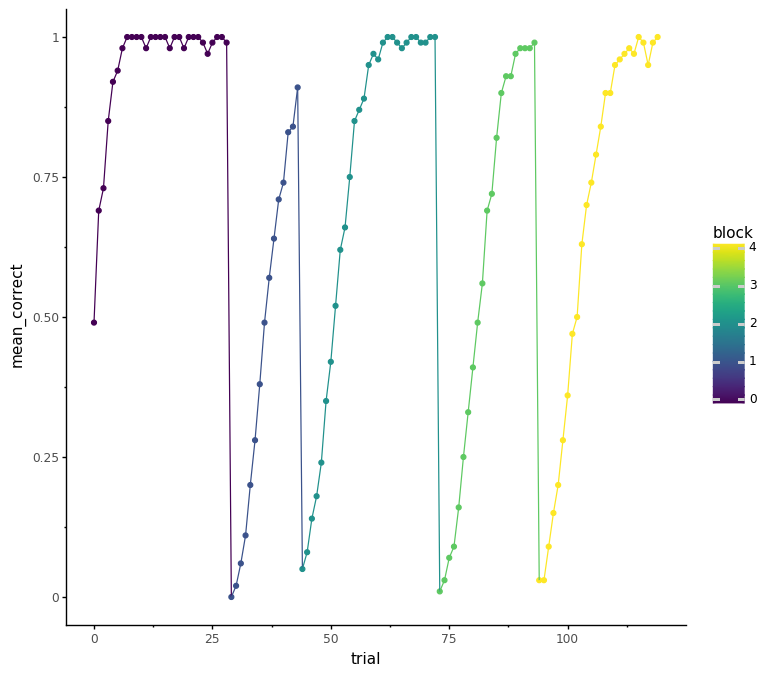

<ggplot: (-9223371863712072041)>

In [128]:
(gg.ggplot(data, gg.aes('trial', 'mean_correct', color='block'))
 + gg.geom_point()
 + gg.geom_line()
)

# Simulating different PCs

In [176]:
# Get fitted PCA
PCs = pd.read_csv("C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots/pca_weights.csv", index_col=0)

# Add columns for simulating data
for i in range(1, 9):
    
    pc = 'PC{}'.format(i)
    
    PCs['PC{}_plus'.format(i)] = PCs.center + 5 * PCs.scale * PCs[pc]
    PCs['PC{}_minus'.format(i)] = PCs.center - 5 * PCs.scale * PCs[pc]

# Check it out
PCs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,center,scale,...,PC4_plus,PC4_minus,PC5_plus,PC5_minus,PC6_plus,PC6_minus,PC7_plus,PC7_minus,PC8_plus,PC8_minus
alpha,-0.238608,-0.270652,-0.035993,0.925816,0.001979,-0.024408,0.103756,-0.004121,0.761392,0.116239,...,1.299472,0.223312,0.762542,0.760242,0.747206,0.775578,0.821695,0.701090,0.758997,0.763787
nalpha,0.309727,-0.561391,-0.106957,-0.087140,0.219089,0.664715,0.150035,0.239832,0.624811,0.139545,...,0.564011,0.685611,0.777675,0.471946,1.088601,0.161020,0.729494,0.520127,0.792148,0.457473
p_switch,0.411637,-0.224207,0.330850,0.050329,-0.812520,-0.074818,0.027048,0.042107,0.134139,0.041246,...,0.144519,0.123760,-0.033425,0.301704,0.118710,0.149569,0.139717,0.128561,0.142823,0.125456
p_reward,0.277990,-0.560011,-0.245145,-0.115461,0.241404,-0.673939,-0.045226,-0.145489,0.909700,0.059167,...,0.875543,0.943858,0.981116,0.838284,0.710325,1.109075,0.896321,0.923080,0.866659,0.952741
beta_RL,-0.433198,-0.111301,-0.383968,-0.233760,-0.314837,-0.114777,0.654577,0.238975,3.527903,1.976465,...,1.217809,5.837996,0.416581,6.639224,2.393643,4.662162,9.996646,-2.940841,5.889529,1.166276
beta_BF,-0.403026,-0.290436,-0.371289,-0.130007,-0.336711,0.210260,-0.607919,-0.267041,3.694916,1.227698,...,2.896866,4.492965,1.628016,5.761815,4.985594,2.404237,-0.036787,7.426618,2.055690,5.334142
persev_RL,-0.320147,-0.292307,0.557535,-0.179216,0.104508,0.087661,0.288374,-0.606080,0.301943,0.207327,...,0.116161,0.487725,0.410280,0.193606,0.392815,0.211071,0.600882,0.003005,-0.326341,0.930228
persev_BF,-0.384483,-0.255973,0.470718,-0.125469,0.100557,-0.180828,-0.287665,0.650977,0.141668,0.079733,...,0.091648,0.191688,0.181757,0.101580,0.069578,0.213758,0.026986,0.256351,0.401190,-0.117854


In [216]:
for pc in range(1, 9):
    for pm in ['plus', 'minus']:

        # Beautify params
        params = PCs['PC{}_{}'.format(pc, pm)]

        params = params.rename({'beta_RL': 'beta', 'persev_RL': 'persev'})
        params = params.drop(['p_switch', 'p_reward', 'beta_BF', 'persev_BF'])
        params['bias'] = 0
        params['calpha'] = params['alpha']
        params['cnalpha'] = params['nalpha']
        params = pd.DataFrame(np.expand_dims(np.array(params), 1), index=params.index).T
        
        # Simulate task
        n_agents = 100
        task_args = {
            'correct_actions': [], 'n_trials': 120,
            'block_lengths_lower': 10, 'block_lengths_upper': 30,
            'forced_rewards': [],
        }
        agent_args = {
            'n_agents': n_agents, 'params': params, 'forced_actions': []
        }
        data = simulate_dataset(task_args, agent_args, 'RL')
        
        # Save simulated data
        file_path = os.path.join('C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat',
                                 'PC{}{}'.format(pc, pm))
        print("Saving simulated data to {}".format(file_path))
        for i in range(n_agents):
            subj_dat = data.drop(columns=['mean_reward', 'mean_correct']
                                ).rename(columns={'action': 'selected_box', 'correct_action': 'correct_box'})
            subj_dat['sID'] = i
            for col_name in ['reward', 'selected_box', 'correct', 'lik']:
                subj_dat[col_name] = subj_dat[col_name].apply(lambda x : x[i])
                subj_dat.to_csv('{}_sID{}.csv'.format(file_path, i), index=False)
        
        # Plot simulated data
        g = (gg.ggplot(data, gg.aes('trial', 'mean_correct', color='block'))
         + gg.geom_point()
         + gg.geom_line()
         + gg.coord_cartesian(ylim=(0, 1))
        )
        g.save(os.path.join(plot_dir, 'g_PC{}_{}.png'.format(pc, pm)), width=4, height=4)

Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC1plus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC1_plus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC1minus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC1_minus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC2plus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC2_plus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC2minus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC2_minus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC3plus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC3_plus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC3minus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC3_minus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC4plus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC4_plus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC4minus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC4_minus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC5plus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC5_plus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC5minus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC5_minus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC6plus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC6_plus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC6minus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC6_minus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC7plus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC7_plus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC7minus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC7_minus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC8plus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC8_plus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving simulated data to C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat\PC8minus


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\g_PC8_minus.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


# Making task structure figure

In [29]:
task = PSTask(
    n_trials=n_trials, block_lengths_lower=10, block_lengths_upper=30,
    correct_actions=[])
corrects = np.array(task.make_task())[:120].astype(float)
p_rew_left = 0.75 * corrects
p_rew_right = 0.75 * (1 - corrects)
structure = pd.DataFrame({'trial': np.arange(120), 'p_rew_left': p_rew_left, 'p_rew_right': p_rew_right})

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/Dropbox/Apps/Overleaf/ProbSwitchPaper/figures/task_structure.eps
  warn('Filename: {}'.format(filename), PlotnineWarning)


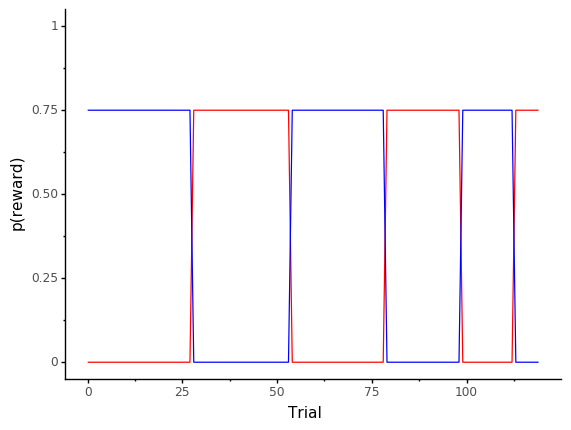

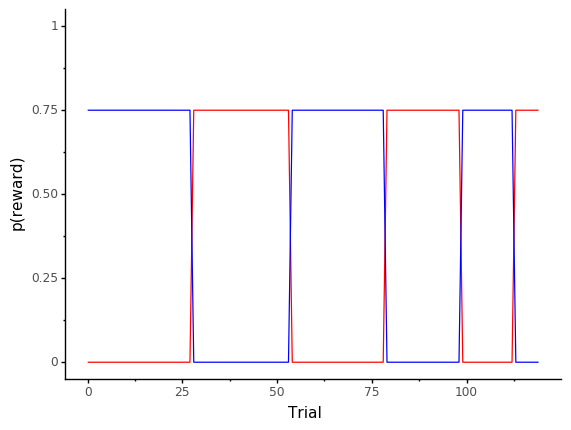

In [30]:
g = (gg.ggplot(structure, gg.aes('trial', 'p_rew_left'))
 + gg.geom_line(gg.aes(y='p_rew_left'), color='red')
 + gg.geom_line(gg.aes(y='p_rew_right'), color='blue')
 + gg.labs(x='Trial', y='p(reward)')
 + gg.coord_cartesian(ylim=(0, 1))
)
g.save('C:/Users/maria/Dropbox/Apps/Overleaf/ProbSwitchPaper/figures/task_structure.eps')
g.draw()

# Putting it all together

## Get true mouse data for IDs and action sequences

In [68]:
fullID_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_AnimalID.csv')).T.values.flatten()
fullID_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_AnimalID.csv')).T.values.flatten()
fullIDs = np.concatenate([fullID_j, fullID_a])
animals = [int(str(fullID)[:-5]) for fullID in fullIDs]
ages = [int(str(fullID)[-5:-2]) for fullID in fullIDs]
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))
true_dat

,Unnamed: 0,action,reward,correct,correct_action,trial,block,fullID,animal,age,gender,agegroup,rew_1ago,rew_2ago,switch,block_length,block_trial,trials2switch,session,rew_12ago
0,0,0,0,0,1,0,0,1404012,14,40,Male,Juvenile,NaN,NaN,NaN,12.0,0.0,0.0,0.0,nn
1,1,0,0,0,1,1,0,1404012,14,40,Male,Juvenile,0.0,NaN,0.0,12.0,1.0,1.0,0.0,0n
2,2,1,1,1,1,2,0,1404012,14,40,Male,Juvenile,0.0,0.0,1.0,12.0,2.0,2.0,0.0,00
3,3,1,1,1,1,3,0,1404012,14,40,Male,Juvenile,1.0,0.0,0.0,12.0,3.0,3.0,0.0,10
4,4,1,1,1,1,4,0,1404012,14,40,Male,Juvenile,1.0,1.0,0.0,12.0,4.0,4.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319720,720,1,1,1,1,720,30,1309021,13,90,Female,Adult,0.0,0.0,1.0,20.0,16.0,16.0,18.0,00
319721,721,1,1,1,1,721,30,1309021,13,90,Female,Adult,1.0,0.0,0.0,20.0,17.0,-3.0,18.0,10
319722,722,1,1,1,1,722,30,1309021,13,90,Female,Adult,1.0,1.0,0.0,20.0,18.0,-2.0,18.0,11
319723,723,1,1,1,1,723,30,1309021,13,90,Female,Adult,1.0,1.0,0.0,20.0,19.0,-1.0,18.0,11


## Get fitted params

In [69]:
fitted_params = pd.DataFrame()
modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f)]
for modelname in modelnames:
    model_params = pd.read_csv(os.path.join(fitted_param_dir, modelname))
    model_params['model'] = modelname.split('_')[1]
    fitted_params = fitted_params.append(model_params, sort=False)
fitted_params

,beta,persev,p_noisy,p_switch,p_reward,sID,slope_variable,fullID,animal,PreciseYrs,...,session,age_z,T1,PDS,model,bias,alpha,nalpha,calpha,cnalpha
0,2.198803,0.511863,0.00001,0.050816,0.948604,1404012,age_z,1404012,14,40,...,0,-1.052255,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
1,1.681370,0.530221,0.00001,0.050816,0.965751,1404112,age_z,1404112,14,41,...,1,-0.997610,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
2,1.625380,0.472071,0.00001,0.050816,0.983376,1404212,age_z,1404212,14,42,...,2,-0.942965,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
3,7.095221,0.436275,0.00001,0.050816,0.993359,1404312,age_z,1404312,14,43,...,3,-0.888320,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
4,2.570709,0.360621,0.00001,0.050816,0.963808,1404412,age_z,1404412,14,44,...,4,-0.833675,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1.224500,0.000000,NaN,NaN,NaN,1308521,age_z,1308521,13,85,...,11,1.406765,0,0,WSLS,0.0,NaN,NaN,NaN,NaN
436,1.072947,0.000000,NaN,NaN,NaN,1308621,age_z,1308621,13,86,...,12,1.461410,0,0,WSLS,0.0,NaN,NaN,NaN,NaN
437,1.072949,0.000000,NaN,NaN,NaN,1308821,age_z,1308821,13,88,...,13,1.570700,0,0,WSLS,0.0,NaN,NaN,NaN,NaN
438,1.208785,0.000000,NaN,NaN,NaN,1308921,age_z,1308921,13,89,...,14,1.625345,0,0,WSLS,0.0,NaN,NaN,NaN,NaN


In [70]:
np.unique(fitted_params.model)

array(['B', 'Bb', 'Bbp', 'Bbpr', 'Bbspr', 'RLab', 'RLabcd', 'RLabcpd',
       'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'WSLS', 'WSLSS',
       'WSLSSd', 'WSLSd'], dtype=object)

### Plot fitted params

In [34]:
fitted_params_ = fitted_params.copy()
fitted_params_['beta'] /= 20
fitted_params_long = fitted_params_.melt(
    id_vars=['sID', 'slope_variable', 'fullID', 'animal', 'PreciseYrs', 'Gender', 'treatment',
             'session', 'age_z', 'T1', 'PDS', 'model'],
    value_name='param_value', var_name='param'
)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\fitted_params.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 32560 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 32560 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


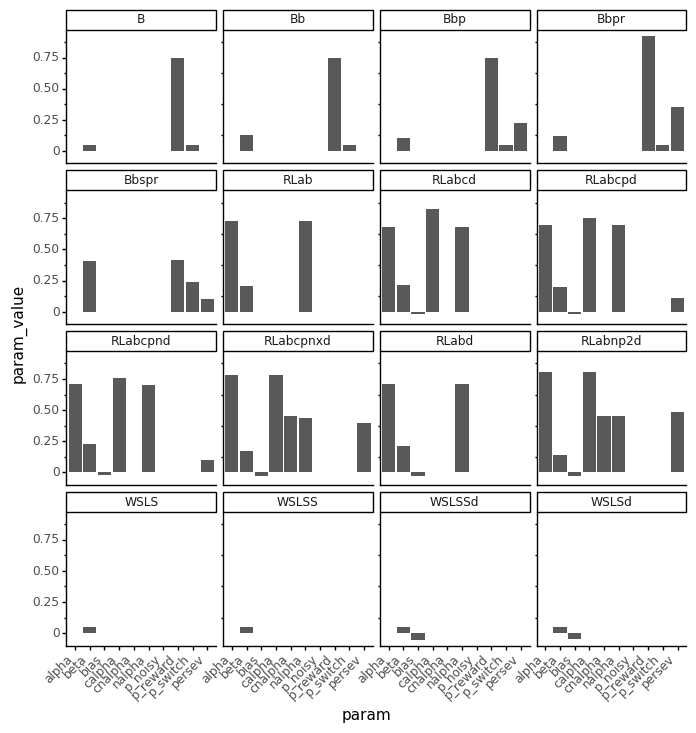

<ggplot: (-9223371863589381053)>

In [37]:
gg.options.figure_size = (8, 8)
g = (gg.ggplot(fitted_params_long, gg.aes('param', 'param_value'))
 + gg.stat_summary(geom='bar')
#  + gg.geom_point(position='jitter', alpha=0.1)
 + gg.facet_wrap('~ model')
 + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
)
g.save(os.path.join(fitted_param_plot_dir, 'fitted_params.png'))
g

## Simulate all fitted models

In [94]:
n_agents = 10
model_names = [modelname.split('_')[1] for modelname in modelnames]
# model_names = ['WSLS', 'WSLSS', 'WSLSd', 'WSLSSd']
print(model_names)

for model_name in model_names:
    print('Working on {}...'.format(model_name))
    sim_data = pd.DataFrame()
    
    if 'B' in model_name:
        param_names = ['beta', 'persev', 'p_switch', 'p_reward', 'bias']
        model_class = 'BF'
    elif 'RL' in model_name:
        param_names = ['alpha', 'nalpha', 'calpha', 'cnalpha', 'beta', 'persev', 'bias']
        model_class = 'RL'
    elif 'WSLS' in model_name:
        param_names = ['beta', 'bias']
        model_class = 'WSLS'

    for animal, age, fullID in zip(animals, ages, fullIDs):
#         if (animal != 23) and (age != 43):  # Error in the Juvi_AnimalID.csv - rerunning fitted_params with fixed one

        # Get task for this mouse
        true_sub = true_dat.loc[(true_dat.age == age) & (true_dat.animal == animal)]
        n_trials = len(np.unique(true_sub.trial))
        correct_actions = true_sub.correct_action.values

        # Get params
        params = fitted_params.loc[
            (fitted_params.PreciseYrs == age) & (fitted_params.animal == animal) & (fitted_params.model == model_name),
            param_names]

        params = params.reset_index()
        if np.isnan(params.bias[0]):
            params.bias[0] = 0
        
        task_args = {
            'correct_actions': correct_actions, 'n_trials': 725,
            'block_lengths_lower': 0, 'block_lengths_upper': 0,
            'forced_rewards': [],
        }
        agent_args = {
            'n_agents': n_agents, 'params': params, 'model_name': model_name, 'forced_actions': [],
        }

        sub_data = simulate_dataset(task_args, agent_args, model_class=model_class, suff='all')
        sub_data['session'] = true_sub.session
        sub_data['animal'] = animal
        sub_data['age'] = age
        sub_data['fullID'] = fullID
        sub_data['model'] = model_name

        sim_data = sim_data.append(sub_data)
    
    save_dir = os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
    print("Saving sim_data ({}) to {}...".format(sim_data.shape, save_dir))
    sim_data.to_csv(save_dir, index=False)

['Bbpr', 'Bbp', 'Bbspr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab', 'WSLSd', 'WSLSSd', 'WSLSS', 'WSLS']
Working on Bbpr...
   index      beta    persev  p_switch  p_reward  bias
0      0  2.198803  0.511863  0.050816  0.948604   NaN


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   index     beta    persev  p_switch  p_reward  bias
0      1  1.68137  0.530221  0.050816  0.965751   NaN
   index     beta    persev  p_switch  p_reward  bias
0      2  1.62538  0.472071  0.050816  0.983376   NaN
   index      beta    persev  p_switch  p_reward  bias
0      3  7.095221  0.436275  0.050816  0.993359   NaN
   index      beta    persev  p_switch  p_reward  bias
0      4  2.570709  0.360621  0.050816  0.963808   NaN
   index      beta    persev  p_switch  p_reward  bias
0      5  2.346299  0.309883  0.050816  0.960862   NaN
   index      beta    persev  p_switch  p_reward  bias
0      6  2.355894  0.350463  0.050816  0.970517   NaN
   index      beta    persev  p_switch  p_reward  bias
0      7  2.878244  0.361113  0.050816  0.955741   NaN
   index      beta   persev  p_switch  p_reward  bias
0      8  3.457411  0.33486  0.050816  0.951661   NaN
   index      beta   persev  p_switch  p_reward  bias
0      9  2.717735  0.31602  0.050816  0.854903   NaN
   index      beta

KeyboardInterrupt: 

### Basic check that simulated behavior looks reasonable

In [ ]:
gg.options.figure_size = (10, 10)
(gg.ggplot(sim_data, gg.aes('trial', 'mean_correct', color='gender'))
 + gg.stat_summary()
)

# Functions for calculating NLLs for datasets

In [58]:
def NLL_from_data_and_params(fitted_param_path, hum_data_path, model_name):
    
    """
    Take full human datasets (including correct actions, chosen actions, and received rewards) and fitted
    parameters (either RL or BF), and calculate the negative log-likelihood of the dataset given the parameters.
    """

    n_agents = 2
    n_trials = 120
    hum_file_names = [f for f in os.listdir(hum_data_path) if '.csv' in f]
    if model_name != 'B':
        fitted_parameters = pd.read_csv(os.path.join(fitted_param_path, "params_{}_age_z_291_pymc3.csv".format(model_name)))

    NLLs = []
    for file_name in hum_file_names:

        sID = int(file_name.split('_')[1].split('.')[0])
        hum_data = pd.read_csv(os.path.join(hum_data_path, "PS_{}.csv".format(sID)))
        correct_actions = hum_data.correct_box[:n_trials]
        actions = hum_data.selected_box[:n_trials]
        rewards = hum_data.reward[:n_trials]
        
        if model_name != 'B':
            subj_params = fitted_parameters[fitted_parameters['sID'] == sID]
        else:
            subj_params = np.array([1])
        if (len(subj_params) > 0) and (len(correct_actions) == n_trials):
            
            if 'RL' in model_name:
                params = pd.DataFrame({
                    'alpha': subj_params['alpha'], 'nalpha': subj_params['nalpha'],
                    'calpha': subj_params['calpha'], 'cnalpha': subj_params['cnalpha'],
                    'beta': subj_params['beta'], 'persev': subj_params['persev'], 'bias': [0]
                })
            elif model_name == 'B':
                params = pd.DataFrame({
                    'p_switch': [0.05], 'p_reward': [0.75],
                    'beta': [np.nan], 'persev': [0], 'bias': [0]
                })
            elif 'B' in model_name:
                params = pd.DataFrame({
                    'p_switch': subj_params['p_switch'], 'p_reward': subj_params['p_reward'],
                    'beta': subj_params['beta'], 'persev': subj_params['persev'], 'bias': [0]
                })
                
            task_args = {
                'correct_actions': correct_actions, 'forced_rewards': rewards, 'n_trials': 120,
                'block_lengths_lower': [], 'block_lengths_upper': []
            }
            agent_args = {
                'n_agents': n_agents, 'params': params, 'forced_actions': actions,
            }

            data = simulate_dataset(task_args, agent_args, model_name[:1])

            NLL = np.sum(data['lik'].apply(lambda x : x[0]))
            NLLs += [[NLL, sID]]
            
    return pd.DataFrame(NLLs, columns=('NLL', 'sID'))

# Example use
hum_data_path = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/"
fitted_param_path = "C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/new_ML_models/MCMC/clustermodels"

NLLs = NLL_from_data_and_params(fitted_param_path, hum_data_path, 'B')
NLLs

,NLL,sID
0,65.739298,10
1,54.849065,100
2,128.189797,101
3,126.960286,102
4,51.953346,103
...,...,...
301,55.951325,93
302,42.416288,94
303,60.247691,96
304,46.207099,98


In [48]:
def make_groups(ages, colname, probs=(1, 3/4, 2/4, 1/4)):

    quantiles_f = np.quantile(ages.loc[(ages.sID < 300) * (ages.Gender=="Female"), colname], q=probs)
    quantiles_m = np.quantile(ages.loc[(ages.sID < 300) * (ages.Gender=="Male"), colname], q=probs)

    groups = np.full(len(ages), np.nan).astype(str)

    for i in range(len(probs)):
      groups[(ages.Gender=="Female") * (ages[colname] <= quantiles_f[i])] = "{}%".format(int(100*probs[i]))
      groups[(ages.Gender=="Male") * (ages[colname] <= quantiles_m[i])] = "{}%".format(int(100*probs[i]))

    groups[ages.sID >= 300] = "Adult"
    groups[ages.sID >= 400] = "UCB"

    return(groups)

# # Example use
# ages_file_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
# ages = pd.read_csv(ages_file_dir)
# ages = ages.rename({'ID': 'sID'}, axis=1)
# ages.Gender = ages.Gender.replace({2: 'Female', 1: 'Male'})
# ages['age_group'] = make_groups(ages, 'PreciseYrs')
# ages['age_group_'] = ages.age_group.replace({'25%': 9, '50%': 11.5, '75%': 14, '100%': 16.5, 'UCB': 21.5, 'Adult': 27.5}).astype(float)
# ages

## Putting it all together

In [49]:
ages_file_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
hum_data_path = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/"
fitted_param_path = "C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/new_ML_models/MCMC/clustermodels"

In [59]:
# Get ages file
ages = pd.read_csv(ages_file_dir)
ages = ages.rename({'ID': 'sID'}, axis=1)
ages.Gender = ages.Gender.replace({2: 'Female', 1: 'Male'})
ages['age_group'] = make_groups(ages, 'PreciseYrs')
ages['age_group_'] = ages.age_group.replace({'25%': 9, '50%': 11.5, '75%': 14, '100%': 16.5, 'UCB': 21.5, 'Adult': 27.5}).astype(float)
ages

# Calculate NLL for each participant, for each model
NLL_model_names = (
    'RLab', 'RLabc', 'RLabcp', 'RLabcpn', 'RLabcpnx', 'RLabnp2',
    'B', 'Bb', 'Bbp', 'Bbpr', 'Bbspr'
)

NLLs = pd.DataFrame({'sID': ages.sID, 'NLL': 0})
for model_name in NLL_model_names:
    print(model_name)
    NLL = NLL_from_data_and_params(fitted_param_path, hum_data_path, model_name)
    NLLs = NLLs.merge(NLL, on='sID', suffixes=("", "_{}".format(model_name)))

# Make NLLs pretty
NLLs = NLLs.drop('NLL', axis=1)
NLLs = NLLs.rename(columns={'NLL_{}'.format(n): n for n in NLL_model_names})
NLLs['RL_minus_BF'] = NLLs['RLabnp2'] - NLLs['Bbspr']
NLLs

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


RLab
RLabc
RLabcp
RLabcpn
RLabcpnx
RLabnp2


KeyboardInterrupt: 

In [ ]:
g = (gg.ggplot(NLLs.merge(ages), gg.aes('PreciseYrs', 'RL_minus_BF'))
 + gg.geom_hline(yintercept=0, linetype='dotted')
 + gg.geom_point(gg.aes(color='Gender'))
 + gg.stat_summary(gg.aes('age_group_'))
 + gg.stat_summary(gg.aes('age_group_'), geom='line')
)
g.save(os.path.join(plot_dir, "h_age_NLL_RL_BF.png"), width=4, height=4)
g

In [ ]:
NLLs_l = pd.melt(NLLs,
                 value_vars=NLL_model_names,
                 id_vars=('sID'), var_name='model_name', value_name='NLL')
NLLs_l = NLLs_l.merge(ages)
NLLs_l

In [ ]:
g = (gg.ggplot(NLLs_l, gg.aes(y='NLL'))
 + gg.geom_point(gg.aes('PreciseYrs', color='Gender'))
 + gg.stat_summary(gg.aes('age_group_'))
 + gg.stat_summary(gg.aes('age_group_'), geom="line")
 + gg.facet_wrap('~ model_name')
)
g.save(os.path.join(plot_dir, "h_age_NLL.png"), width=10, height=8)
g

## Calculate AIC for 0-param Bayes model

In [ ]:
NLL = np.sum(NLLs.B)
n_params = 0
n_trials = 120

AIC = 2 * n_params + 2 * NLL
BIC = np.log(n_trials) * n_params + 2 * NLL
AIC, BIC